In [1]:
import numpy as np
import ipywidgets as widgets
from matplotlib import pyplot as plt
from IPython.display import display, HTML

from utils import *

# Tracking a Moving Car

Bayesian methods have a wide range of applications, e.g., in filtering and smoothing of continuous signals. As an example, let us consider uncertain GPS measurement of a car driving on a road. First, we simulate a set of noisy measurements as well as the underlying true trajectory. For now, we consider trajectory simulated with linear transitions.

In [2]:
x_points, y_points, line_segments = track_example1()

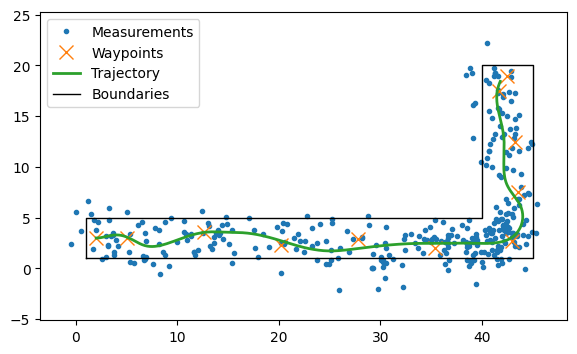

In [3]:
trajectory = MPCTrajectory(x_points, y_points, line_segments, savepath="output/track_L1.pkl")
states, measurements = trajectory.get_data()

trajectory.plot()

In [4]:
show_animation(trajectory, gif_path="animations/car_trajectory")

# Kalman Filtering

As a model of the trajectory of the moving car, we consider a markovian approach. That is, a state-space model of unobserved states approximated using observed measurements. Markovian models have the property that all relevant infomation about the next state is contained in the current state, i.e., all information from previous states can be disregarded. If we denote the state a time $k$ as $x_k$ and the corresponding measurement as $y_k$, the markovian model can be formulated as 

$$
x_k \sim p(x_k | x_{k-1}),
$$

$$
y_k \sim p(y_k | x_{k}).
$$

The task at hand is to estimate the next state based on all knowledge of previous measurement: We want to find the marginal posterior

$$
p(x_k | y_{1:k}).
$$

Now, the closed form solution to the recursive Bayesian filtering equations can be used to describe a linear system descriping the moving car:

$$
\begin{aligned}
\mathbf{x}_k & =\mathbf{A}_{k-1} \mathbf{x}_{k-1}+\mathbf{q}_{k-1}, \\
\mathbf{y}_k & =\mathbf{H}_k \mathbf{x}_k+\mathbf{r}_k,
\end{aligned}
$$

where $\mathbf{A}$ is the trasition function between states, $\mathbf{H}$ is the trasition between measurement, and $\mathbf{q}$ and $\mathbf{r}$ are the state and measurement noise, respectively.

If we assume that the dynamic and the measurement models are Gaussian, i.e.,

$$
\begin{aligned}
p\left(\mathbf{x}_k \mid \mathbf{x}_{k-1}\right) & =\mathrm{N}\left(\mathbf{x}_k \mid \mathbf{A}_{k-1} \mathbf{x}_{k-1}, \mathbf{Q}_{k-1}\right), \\
p\left(\mathbf{y}_k \mid \mathbf{x}_k\right) & =\mathrm{N}\left(\mathbf{y}_k \mid \mathbf{H}_k \mathbf{x}_k, \mathbf{R}_k\right),
\end{aligned}
$$

evaluating the closed form of the posterior results in a Gaussian:

$$
p\left(\mathbf{x}_k \mid \mathbf{y}_{1: k}\right)=\mathrm{N}\left(\mathbf{x}_k \mid \mathbf{m}_k, \mathbf{P}_k\right),
$$

The iterative process of estimating a new state involves a prediction step

$$
\begin{aligned}
\mathbf{m}_k^{-} & =\mathbf{A}_{k-1} \mathbf{m}_{k-1} \\
\mathbf{P}_k^{-} & =\mathbf{A}_{k-1} \mathbf{P}_{k-1} \mathbf{A}_{k-1}^{\top}+\mathbf{Q}_{k-1},
\end{aligned}
$$

and an update step

$$
\begin{aligned}
\mathbf{v}_k & =\mathbf{y}_k-\mathbf{H}_k \mathbf{m}_k^{-}, \\
\mathbf{S}_k & =\mathbf{H}_k \mathbf{P}_k^{-} \mathbf{H}_k^{\top}+\mathbf{R}_k, \\
\mathbf{K}_k & =\mathbf{P}_k^{-} \mathbf{H}_k^{\top} \mathbf{S}_k^{-1}, \\
\mathbf{m}_k & =\mathbf{m}_k^{-}+\mathbf{K}_k \mathbf{v}_k, \\
\mathbf{P}_k & =\mathbf{P}_k^{-}-\mathbf{K}_k \mathbf{S}_k \mathbf{K}_k^{\top}.
\end{aligned}
$$

This process of estimating the next step is known as the $\textit{Kalman filter}$.

Returning to the car example, we illustrate the Kalman filter in action. Here, the dynamics of the system is described by

$$ A =
\left[\begin{array}{llll}
1 & 0 & 0.1 & 0 \\
0 & 1 & 0 & 0.1 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right],
$$

and the measurement as 

$$ H =
\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{array}\right],
$$

and the noise is Gaussian. We then apply Kalman filter to this system.

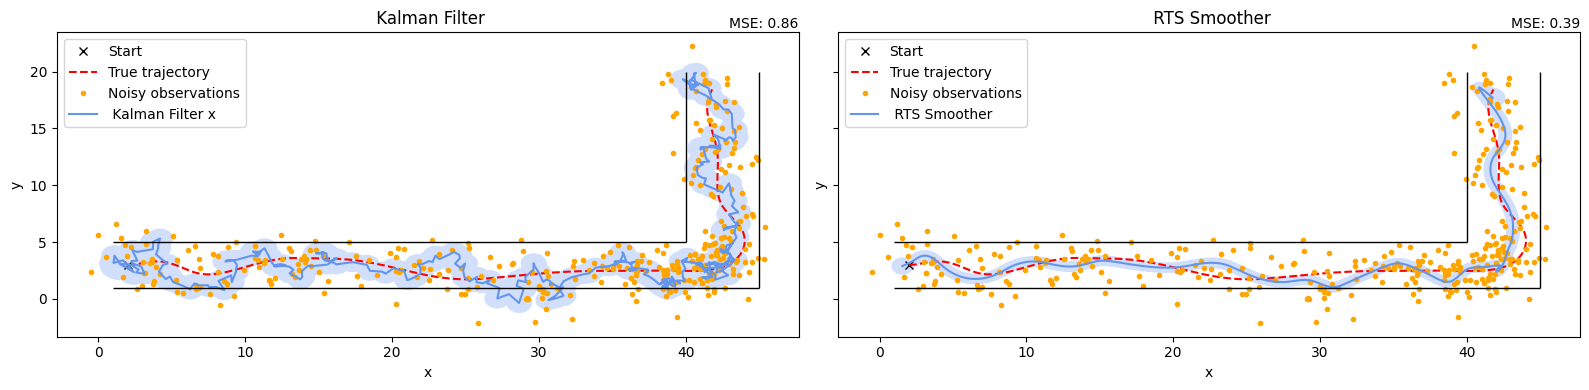

In [5]:
system = StateSpaceModel()

kalman_filter = KF(system.A, system.Q, system.H, system.R)
state_estimates, cov_estimates = kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed)

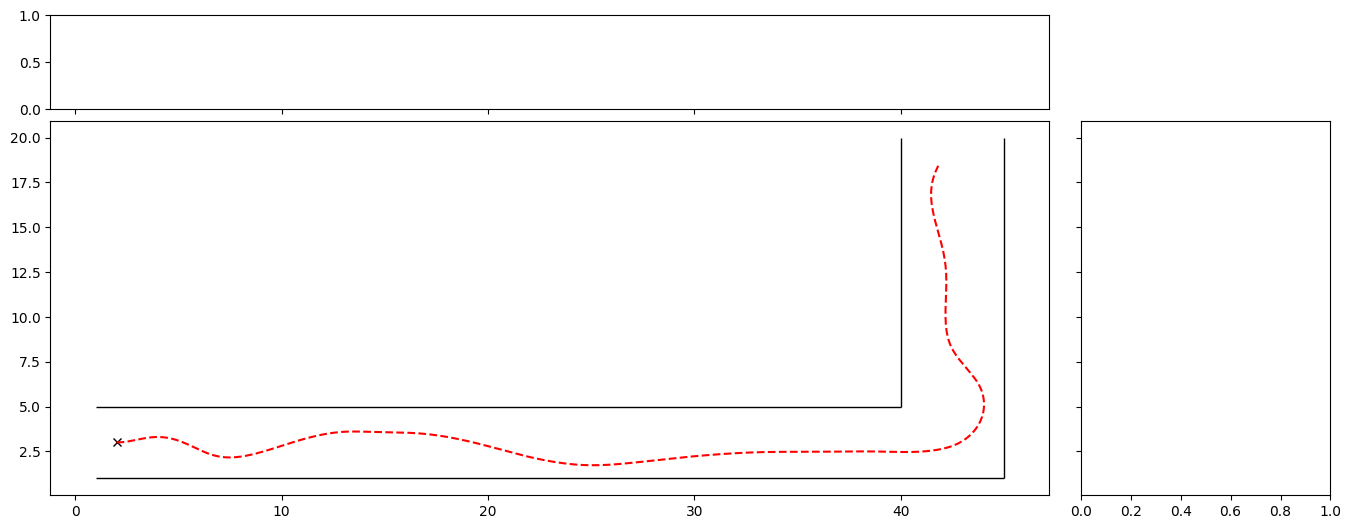

In [6]:
kalman_animation_path = "animations/kalman_filter"
kalman_animation = PlotAnimation(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name=kalman_animation_path)

#show_animation(kalman_animation, kalman_animation_path, filter=True)

kalman_animation.animate()

Image(filename=kalman_animation_path+".gif", format='png')

# Non Linear Dynamics: EKF and UKF

## Extended Kalman Filter (EKF)

The Kalman filter is an incredible effective tool for filtering linear measurents to approximate the hidden states. What happens, then, if the system is not linear? The trasition functions are then drecribed by more general, non-linear functions, that is, 

$$
\begin{aligned}
\mathbf{x}_k & =\mathbf{f}\left(\mathbf{x}_{k-1}\right)+\mathbf{q}_{k-1}, \\
\mathbf{y}_k & =\mathbf{h}\left(\mathbf{x}_k\right)+\mathbf{r}_k.
\end{aligned}
$$

The main issue is that non-linear transformations of Gaussains are not gaussian! Of course, one approach is to simply assume that the marginal posterior distribution is $\textit{reasonably}$ Gaussian such that it can be approximated by

$$
p\left(\mathbf{x}_k \mid \mathbf{y}_{1: k}\right) \simeq \mathrm{N}\left(\mathbf{x}_k \mid \mathbf{m}_k, \mathbf{P}_k\right).
$$

In Extended Kalman Filtering (EKF), we use Taylor series to approximate the non-linearities. This, however, means that we must know the exact dynamics of the system.

The prediction step becomes

$$
\begin{aligned}
\mathbf{m}_k^{-} & =\mathbf{f}\left(\mathbf{m}_{k-1}\right), \\
\mathbf{P}_k^{-} & =\mathbf{F}_{\mathbf{x}}\left(\mathbf{m}_{k-1}\right) \mathbf{P}_{k-1} \mathbf{F}_{\mathbf{x}}^{\top}\left(\mathbf{m}_{k-1}\right)+\mathbf{Q}_{k-1},
\end{aligned}
$$

and the update step becomes

$$
\begin{aligned}
\mathbf{v}_k & =\mathbf{y}_k-\mathbf{h}\left(\mathbf{m}_k^{-}\right), \\
\mathbf{S}_k & =\mathbf{H}_{\mathbf{x}}\left(\mathbf{m}_k^{-}\right) \mathbf{P}_k^{-} \mathbf{H}_{\mathbf{x}}^{\top}\left(\mathbf{m}_k^{-}\right)+\mathbf{R}_k, \\
\mathbf{K}_k & =\mathbf{P}_k^{-} \mathbf{H}_{\mathbf{x}}^{\top}\left(\mathbf{m}_k^{-}\right) \mathbf{S}_k^{-1}, \\
\mathbf{m}_k & =\mathbf{m}_k^{-}+\mathbf{K}_k \mathbf{v}_k, \\
\mathbf{P}_k & =\mathbf{P}_k^{-}-\mathbf{K}_k \mathbf{S}_k \mathbf{K}_k^{\top} .
\end{aligned}
$$


In essense, this means using the Jacobian of the transition function and the measurement model as transition matrices.

Let us see how the EKF compares to the standard KF when the dynamics are non-linear.

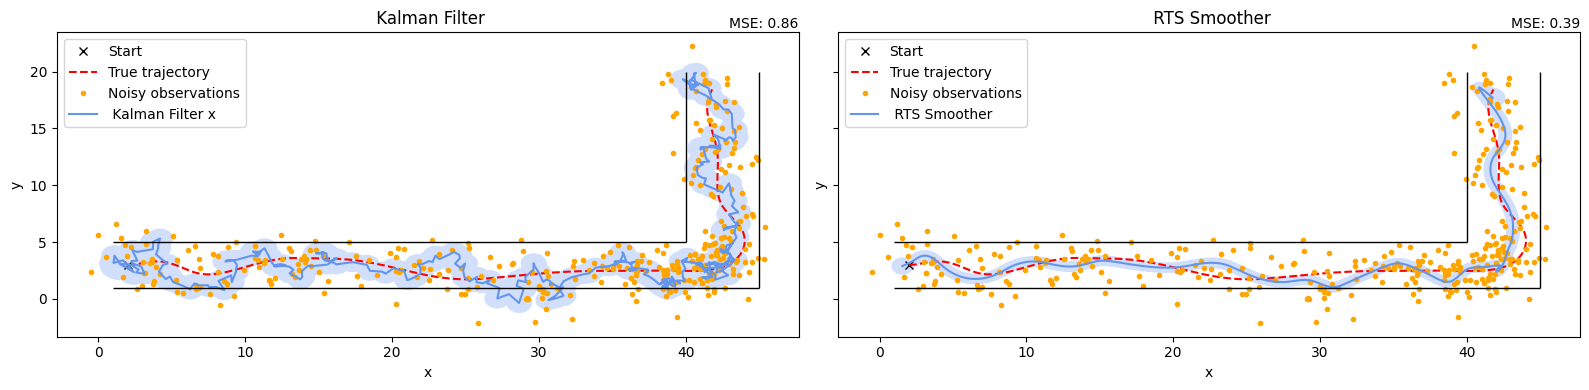

In [7]:
system = StateSpaceModel()

kalman_filter = KF(system.A, system.Q, system.H, system.R)
state_estimates, cov_estimates = kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed)

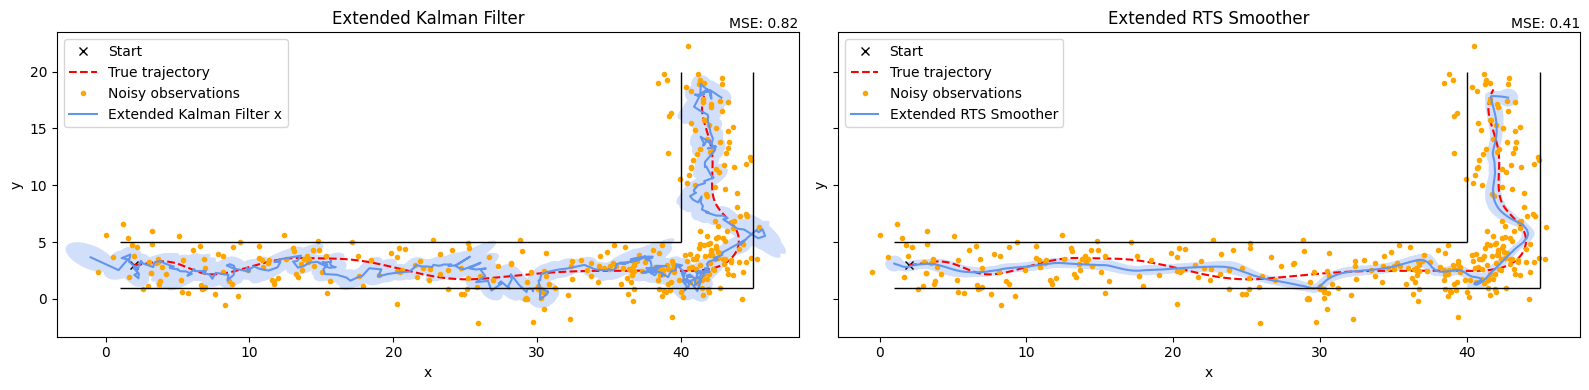

In [8]:
extendted_kalman_filter = EKF(system.f, system.F_jacobian, system.h, system.H_jacobian, system.Q, system.R)
state_estimates, cov_estimates = extendted_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = extendted_kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant="Extended")

NameError: name 'show_filter_animation' is not defined

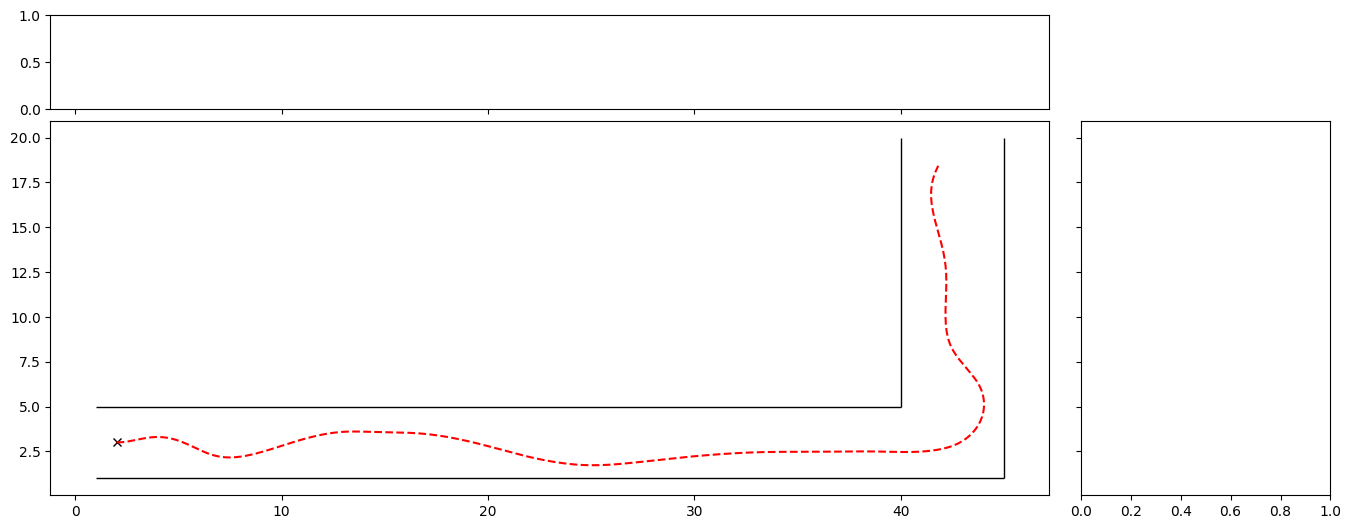

In [9]:
extended_kalman_animation_path = "animations/extended_kalman_filter"
extended_kalman_animation = PlotAnimation(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name=extended_kalman_animation_path)

show_filter_animation(extended_kalman_animation, extended_kalman_animation_path)

## Unscented Kalman Filtering (UKF)

Unscented Kalman Filtering (UKF) uses the unscented transformation and is used for approximating distributations of the same form as EKF. Prediction:

- Prediction:


1. Form the sigma points:
$$
\begin{aligned}
\mathcal{X}_{k-1}^{(0)} & =\mathbf{m}_{k-1}, \\
\mathcal{X}_{k-1}^{(i)} & =\mathbf{m}_{k-1}+\sqrt{n+\lambda}\left[\sqrt{\mathbf{P}_{k-1}}\right]_i, \\
\mathcal{X}_{k-1}^{(i+n)} & =\mathbf{m}_{k-1}-\sqrt{n+\lambda}\left[\sqrt{\mathbf{P}_{k-1}}\right]_i, \quad i=1, \ldots, n,
\end{aligned}
$$



2. Propagate the sigma points through the dynamic model:
$$
\hat{\mathcal{X}}_k^{(i)}=\mathbf{f}\left(\mathcal{X}_{k-1}^{(i)}\right), \quad i=0, \ldots, 2 n .
$$


3. Compute the predicted mean $\mathbf{m}_k^{-}$ and the predicted covariance $\mathbf{P}_k^{-}$:
$$
\begin{aligned}
& \mathbf{m}_k^{-}=\sum_{i=0}^{2 n} W_i^{(\mathrm{m})} \hat{\mathcal{X}}_k^{(i)}, \\
& \mathbf{P}_k^{-}=\sum_{i=0}^{2 n} W_i^{(\mathrm{c})}\left(\hat{\mathcal{X}}_k^{(i)}-\mathbf{m}_k^{-}\right)\left(\hat{\mathcal{X}}_k^{(i)}-\mathbf{m}_k^{-}\right)^{\top}+\mathbf{Q}_{k-1},
\end{aligned}
$$
where the weights $W_i^{(\mathrm{m})}$ and $W_i^{(\mathrm{c})}$ were defined in Equation (5.77).

In [ ]:
alpha = .5
beta = 2
kappa = 0

unscented_kalman_filter = UKF(system.f, system.h, system.Q, system.R, alpha=alpha, beta=beta, kappa=kappa, method='merwe')
state_estimates, cov_estimates = unscented_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = unscented_kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant="Unscented (Merwe)")

unscented_kalman_filter = UKF(system.f, system.h, system.Q, system.R, alpha=alpha, beta=beta, kappa=kappa, method='julier')
state_estimates, cov_estimates = unscented_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = unscented_kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant="Unscented (Julier)")

KeyboardInterrupt: 

In [ ]:
unscented_kalman_animation_path = "animations/unscented_kalman_filter"
unscented_kalman_animation = PlotAnimation(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name=unscented_kalman_animation_path)

show_filter_animation(unscented_kalman_animation, unscented_kalman_animation_path)

## Particle Filtering

The main issue in bayesian inference is computing the posterior, or the expectation of the prosterior, i.e., 

$$
\mathbb{E}\left[\mathrm{g}\left(\mathbf{x}\right) \mid {y}_{1:T}\right]=\int\mathrm{g}\left(\mathbf{x}\right) p(x \mid y_{1:T}) dx,
$$

where $g$ is an arbitrary (possibly nonlinear) function. Monte Carlo methods provides a numerical method for approximating the expectation. In a perfect setting, we simply sample from the posterior and compute the average, i.e.,

$$
\mathbb{E}\left[\mathrm{g}\left(\mathbf{x}\right)  \mid {y}_{1:T}\right]=\frac{1}{N} \sum \mathrm{g}\left(\mathbf{x}^{(i)}\right) .
$$

However, this method can be very cost efficient - especially if $g$ is nonlinear - and it might even be impossible to sample from the posterior. Hence, we introduce importance sampling.

Importance sampling build on the assumption that we can approximate the posterior using an importance distribution $\pi$ from which we can easily draw samples. We draw samples,

$$
\pi(x \mid y_{1:T}), \quad i = 1,...,N,
$$

and form the approximation 

$$
\begin{aligned}
\mathrm{E}\left[\mathrm{g}(\mathbf{x}) \mid \mathbf{y}_{1: T}\right] & \approx \frac{1}{N} \sum_{i=1}^N \frac{p\left(\mathbf{x}^{(i)} \mid \mathbf{y}_{1: T}\right)}{\pi\left(\mathbf{x}^{(i)} \mid \mathbf{y}_{1: T}\right)} \mathrm{g}\left(\mathbf{x}^{(i)}\right) \\
& =\sum_{i=1}^N \tilde{w}^{(i)} \mathrm{g}\left(\mathbf{x}^{(i)}\right),
\end{aligned}
$$

where $\pi$ must have a support greater or equal to the posterior. In this way, weights are used to attribute $\textit{importance}$ to samples approximating the posterior probability density. 


Importance sampling approximations can be used sequentially to generate filtering distributions of generic state space models. At each step, the expected value can be found using importance sampling. A problem in the sequential importance sampling (SIS) arises when nearly all weights are equal to zero. This is called the $\textit{degeneracy problem}$. Several methods exist for resampling particles - these are called sequential importance resampling (SIR). Briefly, the resampling procedure can be described as follows:

1. Interpret each weight $w_k^{(i)}$ as the probability of obtaining the sample index $i$.
2. Draw new samples from this discrete distribution.
3. Set all weights to $1/N$.

This procedure is normally what is referred to as the particle filter.

In [ ]:
particle_filter = PF(system.f, system.h, system.Q, system.R)
state_estimates, cov_estimates, particle_history, weights_history = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed, cov_estimates_smoothed = particle_filter.smoother(state_estimates, cov_estimates, particle_history, weights_history, verbose=True)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant="Particle")

  0%|          | 0/340 [00:00<?, ?it/s]

KeyboardInterrupt: 

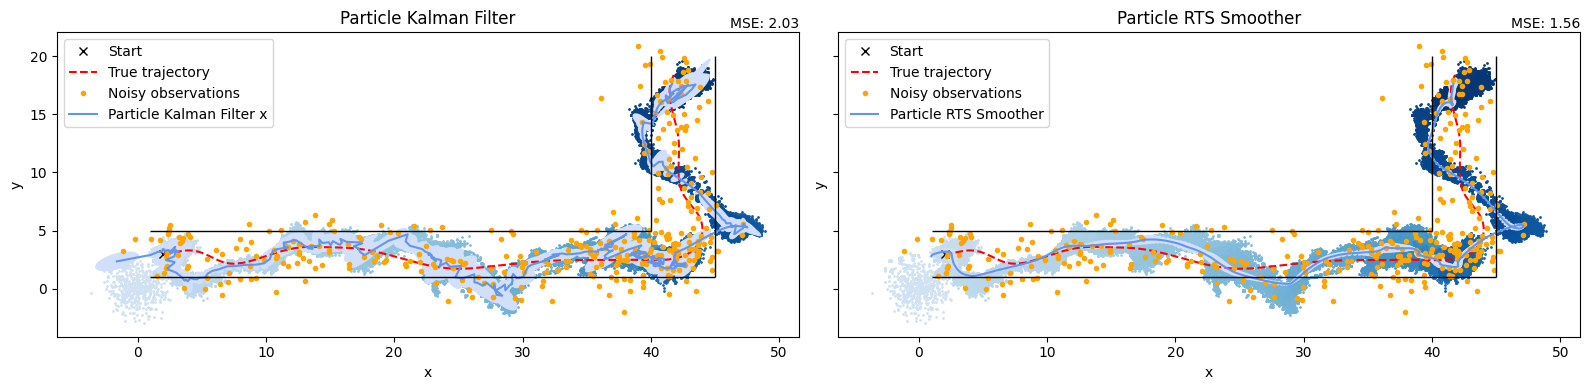

In [ ]:
visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, particle_history, variant="Particle")

In [ ]:
particle_animation_path = "animations/particle_filter"

particle_animation = PlotAnimation(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name=particle_animation_path)

show_filter_animation(particle_animation, particle_animation_path)